In [178]:
%config InlineBackend.figure_formats = ['svg']

from patch.utils import embed_to_distrib, top_vals, format_token, intervene_node_and_pos
from patch.models.gpt2 import GPT2, create_gpt2
import sys

import torch
import pandas as pd
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text, scale_x_discrete

config, tokenizer, model = create_gpt2('gpt2')
model = GPT2(config, model, verbose=False)

loaded model


In [183]:
inputs = [
    tokenizer("Lucy has a pet cat named Tom. Lucy loved to play with him. One sunny day, they went to the park to play. While playing,", return_tensors="pt"),
    tokenizer("Lucy has a pet cat named Tom. Lucy loved to play with toys. One sunny day, they went to the park to play. While playing,", return_tensors="pt")
]
print(inputs)
assert len(inputs[0]['input_ids'][0]) == len(inputs[1]['input_ids'][0])

[{'input_ids': tensor([[25596,   948,   468,   257,  4273,  3797,  3706,  4186,    13, 22162,
          6151,   284,   711,   351,   683,    13,  1881, 27737,  1110,    11,
           484,  1816,   284,   262,  3952,   284,   711,    13,  2893,  2712,
            11]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[25596,   948,   468,   257,  4273,  3797,  3706,  4186,    13, 22162,
          6151,   284,   711,   351, 14958,    13,  1881, 27737,  1110,    11,
           484,  1816,   284,   262,  3952,   284,   711,    13,  2893,  2712,
            11]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}]


In [184]:
model.cache = {}
res1, cache1 = model(inputs, which=lambda x: 0, verbose=False)
distrib1 = embed_to_distrib(model, res1.hidden_states, logits=False)
top_vals(tokenizer, distrib1[0][-1], n=10)
print('-----')

res2, cache2 = model(inputs, which=lambda x: 1, verbose=False)
distrib2 = embed_to_distrib(model, res2.hidden_states, logits=False)
top_vals(tokenizer, distrib2[0][-1], n=10)

_Tom                 0.3359508216381073
_they                0.15104644000530243
_Lucy                0.08007156848907471
_she                 0.06771314144134521
_the                 0.04065266624093056
_he                  0.02892112173140049
_a                   0.023351987823843956
_one                 0.010280328802764416
_their               0.006747561972588301
_I                   0.005566762760281563
-----
_Tom                 0.3053414225578308
_they                0.18140359222888947
_Lucy                0.0882069393992424
_she                 0.07809039205312729
_the                 0.044189080595970154
_a                   0.02426077239215374
_he                  0.01345102209597826
_one                 0.011430375277996063
_their               0.008281435817480087
_I                   0.006608281284570694


0     Lu
1     cy
2     _has
3     _a
4     _pet
5     _cat
6     _named
7     _Tom
8     .
9     _Lucy
10    _loved
11    _to
12    _play
13    _with
14    _him / _toys
15    .
16    _One
17    _sunny
18    _day
19    ,
20    _they
21    _went
22    _to
23    _the
24    _park
25    _to
26    _play
27    .
28    _While
29    _playing
30    ,
{'f0', 'a5', 'a8', 'f5', 'f1', 'a6', 'a11', 'a9', 'f11', 'a7', 'emb', 'a0', 'f8', 'f6', 'a2', 'a10', 'f9', 'f10', 'f2', 'f7', 'ln_final', 'a3', 'a4', 'f4', 'a1', 'f3'}
{'f0', 'a5', 'a8', 'f5', 'f1', 'a6', 'a11', 'a9', 'f11', 'a7', 'emb', 'a0', 'f8', 'f6', 'a2', 'a10', 'f9', 'f10', 'f2', 'f7', 'ln_final', 'a3', 'a4', 'f4', 'a1', 'f3'}


/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_5105/1849366591.py:41: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.


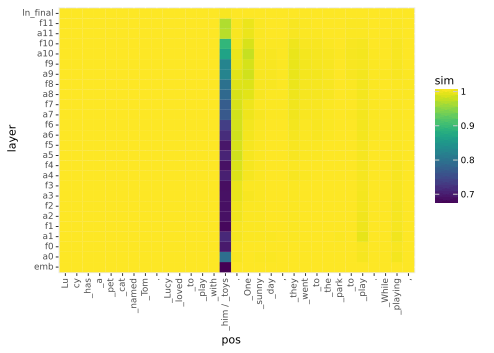

In [185]:
import torch
import pandas as pd
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text, scale_x_discrete

data = []

toks = []
for i in range(len(inputs[0]['input_ids'][0])):
    tok1 = format_token(tokenizer, inputs[0]['input_ids'][0][i])
    tok2 = format_token(tokenizer, inputs[1]['input_ids'][0][i])
    toks.append(tok1 + (' / ' + tok2 if tok1 != tok2 else ''))
    print(f"{i:<5}", toks[-1])

for key in cache1:
    if 'head' in key.parent:
        continue
    ret1 = cache1[key].hidden_states
    for key2 in cache2:
        if key2.parent == key.parent:
            ret2 = cache2[key2].hidden_states

    # get cosine similarity
    sim = torch.nn.functional.cosine_similarity(ret1, ret2, dim=-1)
    for tok in range(sim.shape[1]):
        data.append({
            'layer': key.parent,
            'pos': tok,
            'sim': sim[0, tok].item()
        })

layers = config.n_layer
order = ["emb"]
for i in range(layers):
    order.append(f"a{i}")
    order.append(f"f{i}")
order.append("ln_final")

df = pd.DataFrame(data)
df["pos"] = df["pos"].astype("category")
df["layer"] = df["layer"].astype("category")
df["layer"].cat.reorder_categories(order, inplace=True)

print(set(df["layer"].cat.categories))
print(set(order))
assert set(df["layer"].cat.categories) == set(order)

g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="sim", color="sim"))
    + theme(axis_text_x=element_text(rotation=90))
    + scale_x_discrete(labels=toks)
)

print(g)

100%|██████████| 25/25 [00:57<00:00,  2.31s/it]


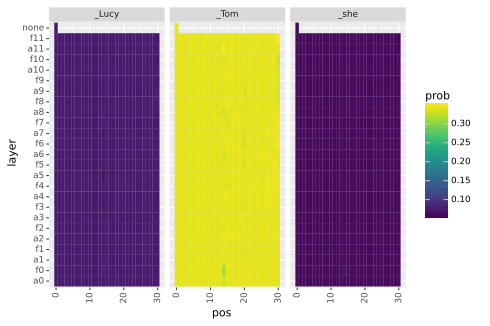

In [186]:
%config InlineBackend.figure_formats = ['svg']

df, nodes, g = intervene_node_and_pos(model, tokenizer, inputs, tokens=[' Tom', ' Lucy', ' she'], plot=True, pause=False)
print(g)

In [189]:
df[df.token == '_Tom'].sort_values('prob', ascending=True).head(10)

,token,prob,layer,pos,id
2091,_Tom,0.306391,f0,14,23
696,_Tom,0.323996,a8,14,8
279,_Tom,0.324001,f10,30,3
2184,_Tom,0.325589,a0,14,24
993,_Tom,0.327717,f6,20,11
1179,_Tom,0.327742,f5,20,13
1068,_Tom,0.327893,a6,14,12
900,_Tom,0.329334,a7,20,10
372,_Tom,0.329469,a10,30,4
528,_Tom,0.329562,a9,20,6


In [188]:
df[df.token == '_Lucy'].sort_values('prob', ascending=False).head(10)

,token,prob,layer,pos,id
2092,_Lucy,0.088459,f0,14,23
559,_Lucy,0.087989,a9,30,6
373,_Lucy,0.086630,a10,30,4
697,_Lucy,0.085242,a8,14,8
652,_Lucy,0.084041,f8,30,7
2185,_Lucy,0.083406,a0,14,24
187,_Lucy,0.082559,a11,30,2
1813,_Lucy,0.082530,a2,14,20
1210,_Lucy,0.082418,f5,30,13
1999,_Lucy,0.082396,a1,14,22


# Some more stuff

In [58]:
NODE = "a12"
POS = 8
def which(path, node, pos):
    if f"{NODE}.head.pos{POS}" in path or f"{NODE}.pos{POS}" in path:
        return 1
    if f"{node}.head.pos{pos}" in path or f"{node}.pos{pos}" in path:
        return 1
    return 0


def branch(path, node, pos):
    if path[-1] == f"{NODE}":
        return "positions"
    if path[-1] == f"{NODE}.head":
        return "positions"
    if path[-1] == f"{node}":
        return "positions"
    if path[-1] == f"{node}.head":
        return "positions"
    return False

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [02:30<00:00,  3.07s/it]


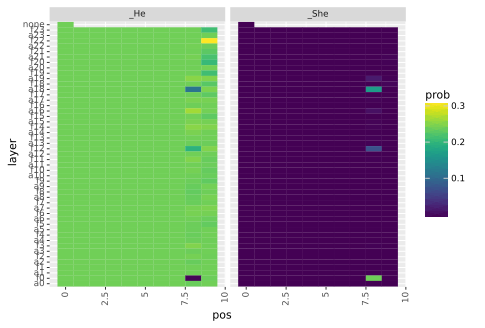

In [60]:
%config InlineBackend.figure_formats = ['svg']

df, nodes, g = intervene_node_and_pos(model, tokenizer, inputs, tokens=[' He', ' She'], plot=True, pause=False, which=which, branch=branch)
print(g)

In [61]:
# top interventions for She
df[df.token == '_She'].sort_values('prob', ascending=False).head(10)

,token,prob,layer,pos,id
939,_She,0.234294,f0,8,47
239,_She,0.165870,a18,8,12
459,_She,0.075799,f12,8,23
199,_She,0.021859,a19,8,10
319,_She,0.012777,a16,8,16
221,_She,0.004263,f18,9,11
121,_She,0.003527,a21,9,6
379,_She,0.003180,f14,8,19
359,_She,0.003048,a15,8,18
279,_She,0.002944,a17,8,14
